In [2]:
%matplotlib inline

import pickle
from transformers import AutoTokenizer, AutoModelForCausalLM

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import numpy as np
from IPython.display import clear_output
from collections import Counter
os.chdir("../")

from src import utils
from src.utils import optimal_tokenization
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import LogLocator


t_val = 2.353 # t-value for 90% confidence interval
os.chdir("/NL/token-pricing/work")


In [3]:
class CustomLogLocator(LogLocator):
    def __init__(self, base=10.0, subs=None, numticks=10, threshold=0.2):
        super().__init__(base=base, subs=subs, numticks=numticks)
        self.threshold = threshold
 
    def tick_values(self, vmin, vmax):
        ticks = super().tick_values(vmin, vmax)
        # Filter ticks greater than the threshold
        return [tick for tick in ticks if tick > self.threshold]

# LLAMA 1B

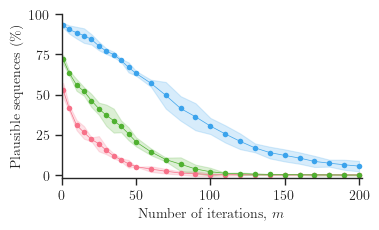

In [114]:
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)

ax.set_ylim(-2, 100)
ax.set_xlim(0,202)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T145_success.pdf', dpi=300)



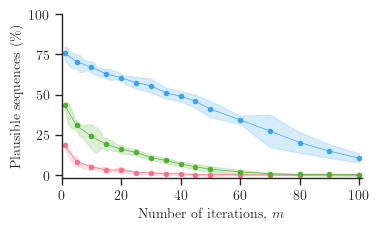

In [115]:
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)

ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T13_success.pdf', dpi=300)



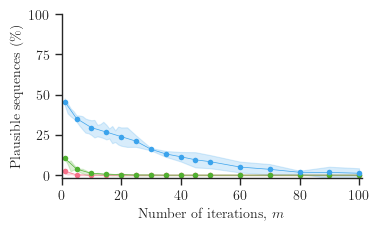

In [116]:
num_prompts = len(data_09["generated_outputs"][0])
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T115_success.pdf', dpi=300)



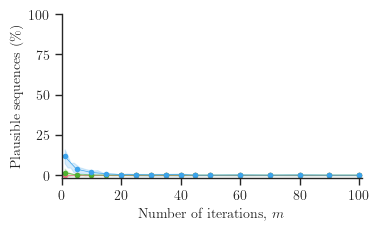

In [117]:
num_prompts = len(data_09["generated_outputs"][0])
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T10_success.pdf', dpi=300)



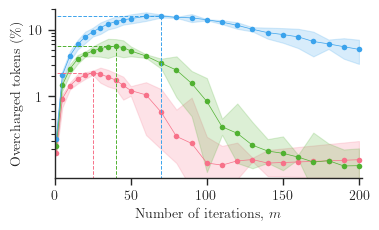

70 15.913906482390217
40 5.632332653621815
25 2.2595836747161315


In [118]:

#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)
ax.set_ylim(-0.1,20)
ax.set_xlim(0,202)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T145_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


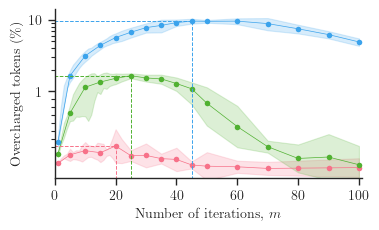

45 9.582649620611361
25 1.6443092214221444
20 0.3082898736656187


In [119]:

#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,14)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T13_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


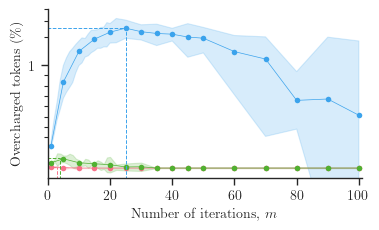

25 2.505449652969393
4 0.09596285071944731
3 0.0144990029450287


In [8]:

#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)
ax.set_yscale("log", base = 14)
ax.set_yscale("symlog", linthresh=1)


ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )
ax.set_ylim(-0.1,4)
ax.set_xlim(0,101)



fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T115_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


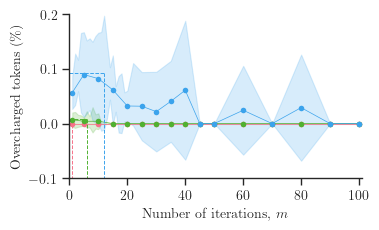

12 0.09324548758794621
6 0.0076927803088921165
1 0.0


In [121]:

#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L1B/heuristic_model_Llama-3.2-1B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

#ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,0.2)
ax.set_xlim(0,101)




fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_1B_topp_T10_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


# Lama 3B

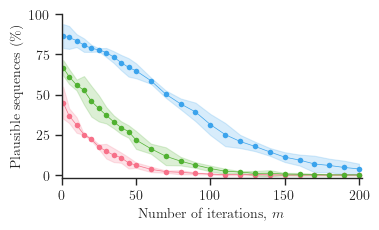

In [122]:
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,202)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T145_success.pdf', dpi=300)



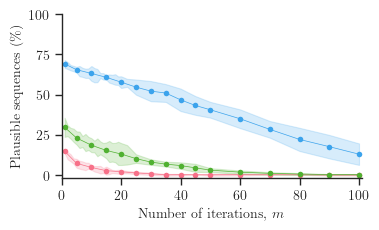

In [123]:
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_percent_T13_success.pdf', dpi=300)



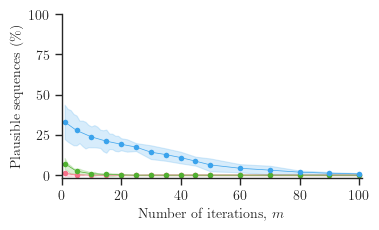

In [124]:
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T115_success.pdf', dpi=300)



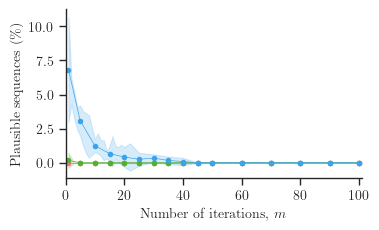

In [125]:
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T10_success.pdf', dpi=300)



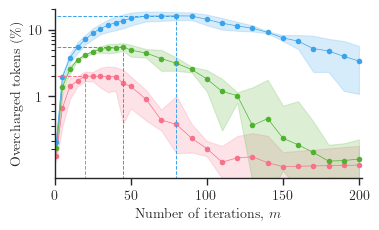

80 15.9746831847053
45 5.509912575489554
20 2.0229908838503756


In [126]:

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,20)
ax.set_xlim(0,202)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T145_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


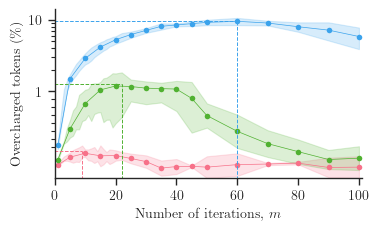

60 9.5193905887884
22 1.2505439994666037
9 0.2396306971710432


In [127]:

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,14)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T13_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


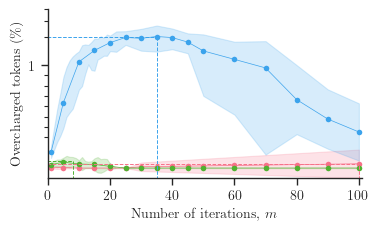

35 2.036862300392652
8 0.06523545108901961
100 0.04145885416018872


In [4]:

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)




ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )
ax.set_ylim(-0.1,4)
ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T115_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


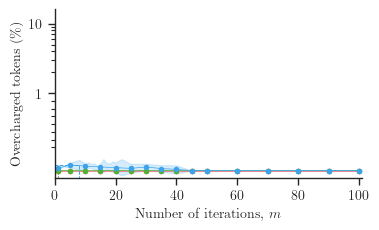

8 0.07271981556227665
1 0.0007921796029595829
1 0.0


In [129]:

#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/L3B/heuristic_model_Llama-3.2-3B-Instruct_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,16)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Llama_3B_topp_T10_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


# Mistral

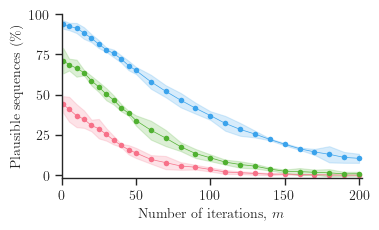

In [130]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,202)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T145_success.pdf', dpi=300)



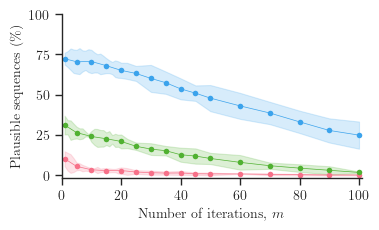

In [131]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T13_success.pdf', dpi=300)



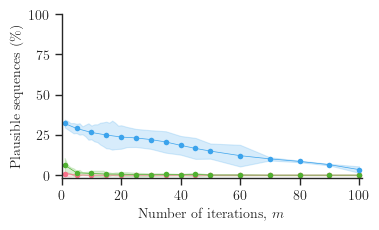

In [132]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_percent_T115_success.pdf', dpi=300)



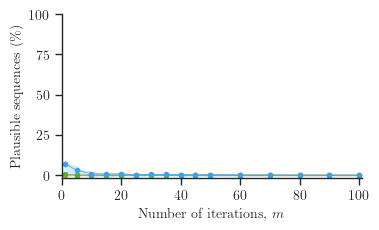

In [133]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T10_success.pdf', dpi=300)



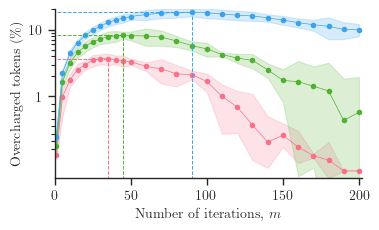

90 18.006749526424674
45 8.25618510299436
35 3.6641803927820824


In [134]:

#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,20)
ax.set_xlim(0,202)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T145_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


32


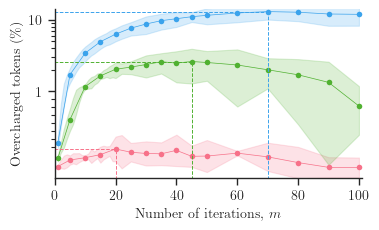

70 13.023711236736558
45 2.601047919922714
20 0.270009937852615


In [135]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]



percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )



print(len(percentage_09[0]))


mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)


splits_new = np.array(splits)[indices]
mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})



sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))



sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4, marker ="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



# Plot the horizontal and vertical lines
#plt.axhline(y=y_max_085, xmin=0, xmax= x_max_085, color=palette[2], linestyle='--')
#plt.axvline(x=x_max_085, ymin=0, ymax= y_max_085, color=palette[2], linestyle='--')

ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)



# Annotate the maximum point
#plt.scatter([x_max], [y_max], color='black', zorder=5)
#plt.text(x_max, y_max, f"({x_max:.2f}, {y_max:.2f})", fontsize=10, ha='left')


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")
ax.set_ylim(-0.1,14)
ax.set_xlim(0,101)

#ax.set_yticks( [0, 2,4, round(y_max_085,1), round(y_max_09,1), round(y_max_095,1)], [0,2,4, round(y_max_085,1), round(y_max_09,1), round(y_max_095,1)] )
plt.legend().set_visible(False)

ax.set_yscale("log", base = 14)
ax.set_yscale("symlog", linthresh=1)


ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T13_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)

0
1
2


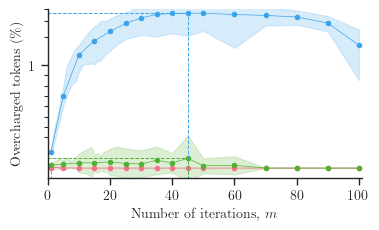

45 3.6355469679779966
45 0.09385182997485549
1 0.004662038437058636


In [9]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]



percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    print(seq_idx)
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)


splits_new = np.array(splits)[indices]
mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})



sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))



sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4, marker ="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



# Plot the horizontal and vertical lines
#plt.axhline(y=y_max_085, xmin=0, xmax= x_max_085, color=palette[2], linestyle='--')
#plt.axvline(x=x_max_085, ymin=0, ymax= y_max_085, color=palette[2], linestyle='--')

ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)



# Annotate the maximum point
#plt.scatter([x_max], [y_max], color='black', zorder=5)
#plt.text(x_max, y_max, f"({x_max:.2f}, {y_max:.2f})", fontsize=10, ha='left')


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")


#ax.set_yticks( [0, 2,4, round(y_max_085,1), round(y_max_09,1), round(y_max_095,1)], [0,2,4, round(y_max_085,1), round(y_max_09,1), round(y_max_095,1)] )
plt.legend().set_visible(False)

ax.set_yscale("log", base = 14)
ax.set_yscale("symlog", linthresh=1)


ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )
ax.set_ylim(-0.1,4)
ax.set_xlim(0,101)

fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T115_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)

0
1
2


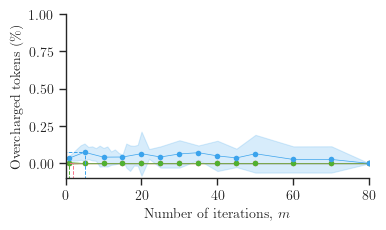

5 0.07470463511140844
1 0.004261845371526519
2 0.0007691568118450148


In [137]:
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/M8B/heuristic_model_Ministral-8B-Instruct-2410_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    print(seq_idx)
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)



mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})



sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))



sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4, marker ="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



# Plot the horizontal and vertical lines
#plt.axhline(y=y_max_085, xmin=0, xmax= x_max_085, color=palette[2], linestyle='--')
#plt.axvline(x=x_max_085, ymin=0, ymax= y_max_085, color=palette[2], linestyle='--')

ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)



# Annotate the maximum point
#plt.scatter([x_max], [y_max], color='black', zorder=5)
#plt.text(x_max, y_max, f"({x_max:.2f}, {y_max:.2f})", fontsize=10, ha='left')


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")
ax.set_ylim(-0.1,1)
ax.set_xlim(0,80)

#ax.set_yticks( [0, 2,4, round(y_max_085,1), round(y_max_09,1), round(y_max_095,1)], [0,2,4, round(y_max_085,1), round(y_max_09,1), round(y_max_095,1)] )
plt.legend().set_visible(False)








fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Mistral_8B_topp_T10_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)

# Gemma 1B


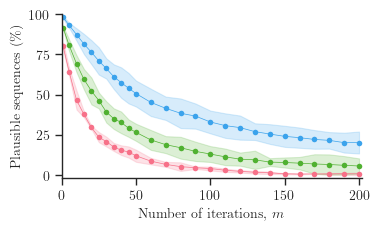

In [138]:
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,202)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T145_success.pdf', dpi=300)



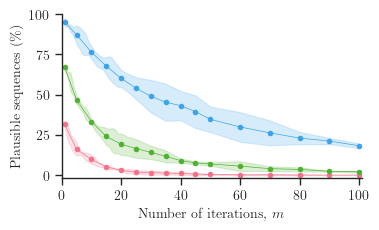

In [139]:
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T13_success.pdf', dpi=300)



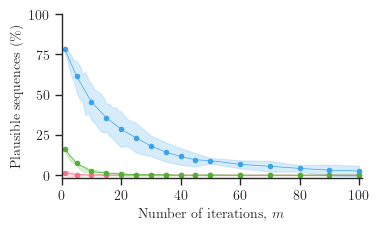

In [140]:
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T115_success.pdf', dpi=300)



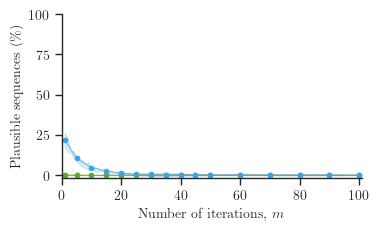

In [141]:
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T10_success.pdf', dpi=300)



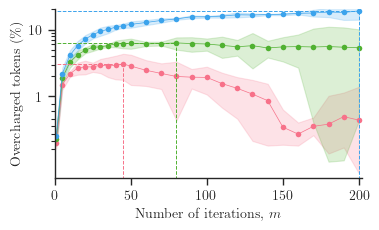

200 18.98466391278057
80 6.311452586526006
45 3.052115448013261


In [142]:

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,20)
ax.set_xlim(0,202)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T145_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


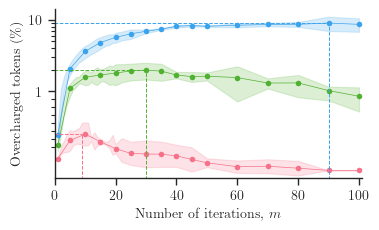

90 9.00509971125321
30 1.9738189027121498
9 0.4643279260582796


In [157]:

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )
ax.set_ylim(-0.1,14)
ax.set_xlim(0,101)



fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T13_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


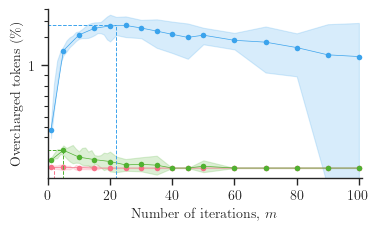

22 2.7119719246428953
5 0.17301210051208482
2 0.009439613165805131


In [5]:

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)




ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )
ax.set_ylim(-0.1,4)
ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T115_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


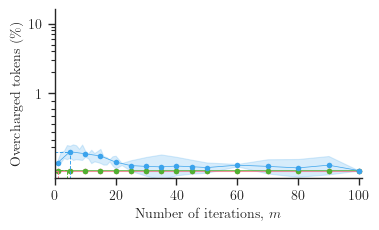

5 0.24431297477856573
4 0.00168358671313366
1 0.0


In [145]:

#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G1B/heuristic_model_Gemma-3-1b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,16)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_1B_topp_T10_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


# Gemma 4B

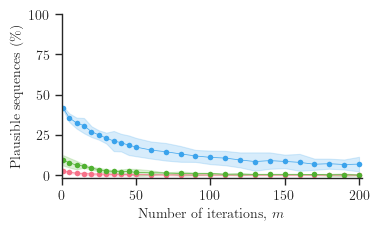

In [146]:
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,202)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T145_success.pdf', dpi=300)



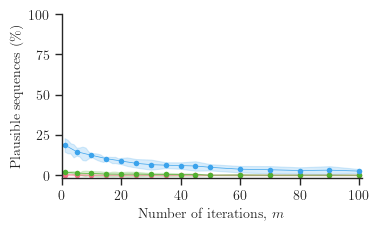

In [147]:
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T13_success.pdf', dpi=300)



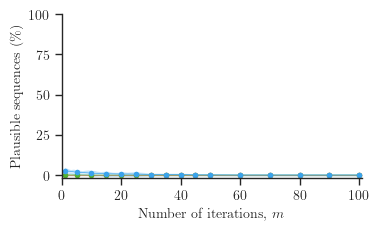

In [148]:
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T115_success.pdf', dpi=300)



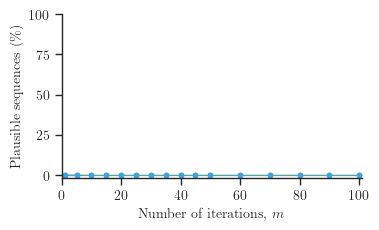

In [149]:
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)

num_prompts = len(data_09["generated_outputs"][0])

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  / num_prompts * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]   / num_prompts * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value




# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Plausible sequences (\%)")

plt.legend().set_visible(False)
ax.set_ylim(-2, 100)

ax.set_xlim(0,101)


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T10_success.pdf', dpi=300)



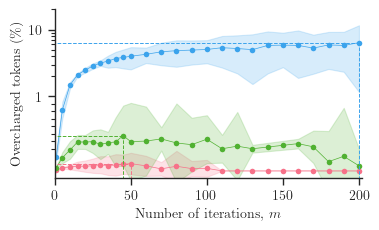

200 6.365187921378954
45 0.47372935432765706
50 0.09818635527539284


In [150]:

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.45_splits_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.45_splits_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.45_splits_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]

indices = [splits.index(element) for element in [1,5,10, 15, 20 ,25 ,30 ,35, 40 ,45 ,50, 60,70,80,90,100, 110,  120, 130,  140,  150,  160,  170, 180 ,190, 200]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,20)
ax.set_xlim(0,202)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T145_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


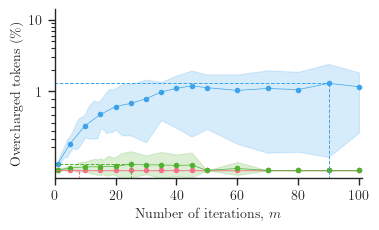

90 1.2866290320423877
25 0.07722523575130831
8 0.002714054050386413


In [158]:

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.3_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,14)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T13_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


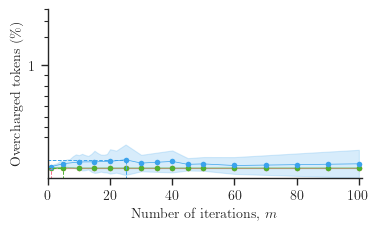

25 0.08059253137331372
5 0.0019421624036201908
1 0.0


In [6]:

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.15_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,4)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )
ax.set_ylim(-0.1,4)
ax.set_xlim(0,101)

fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T115_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)


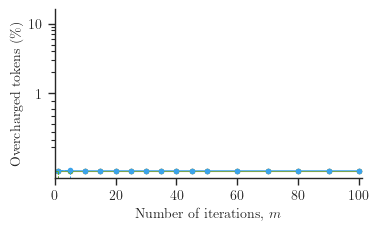

5 0.002061634628864534
1 0.0
1 0.0


In [153]:

#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.9_k_None_prompt_idare you .pkl", "rb") as f:
    data_09 = pickle.load(f)


#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.95_k_None_prompt_idare you .pkl", "rb") as f:
    data_095 = pickle.load(f)
    
#Load pickle
with open("outputs/heuristic_new/G4B/heuristic_model_Gemma-3-4b-it_T_1.0_splits_[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]_numseq_3_p_0.99_k_None_prompt_idare you .pkl", "rb") as f:
    data_099 = pickle.load(f)


splits = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]

indices = [splits.index(element) for element in [1, 5 ,10 ,15 ,20, 25 ,30, 35,40,45,50,60,70,80,90,100]  ]


percentage_09 = []
percentage_095 = []
percentage_099 = []


for seq_idx in range(len((data_099["top_p_count"]))):
    percentage_09.append( np.array( [ data_09["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_09["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_095.append( np.array( [ data_095["top_p_count"][seq_idx][i]  * splits[i]/ sum(data_095["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )
    percentage_099.append( np.array( [ data_099["top_p_count"][seq_idx][i]  * splits[i] / sum(data_099["generated_outputs"][seq_idx]) * 100  for i in range( len(splits))] ) )






mean_09 = np.mean( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)
std_09 = np.std( np.stack((percentage_09[0], percentage_09[1], percentage_09[2]),axis=0) , axis=0)

mean_095 = np.mean( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)
std_095 = np.std( np.stack((percentage_095[0], percentage_095[1], percentage_095[2]),axis=0) , axis=0)

mean_099 = np.mean( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)
std_099 = np.std( np.stack((percentage_099[0], percentage_099[1], percentage_099[2]),axis=0) , axis=0)





splits_new = np.array(splits)[indices]


mean_09_new = np.array(mean_09)[indices]
mean_095_new = np.array(mean_095)[indices]
mean_099_new = np.array(mean_099)[indices]
std_09_new = np.array(std_09)[indices]
std_095_new = np.array(std_095)[indices]
std_099_new = np.array(std_099)[indices]


# df = pd.DataFrame({
#     'mean_percent':np.concatenate( (mean_09, mean_095, mean_099) ),
#     'top-p': ['085'] * len(mean_09) + ['09'] * len(mean_095) + ['095'] * len(mean_099),
#     'splits' : splits * 3, 
# })

df = pd.DataFrame({
    'mean_percent':np.concatenate( (mean_09_new, mean_095_new, mean_099_new) ),
    'top-p': ['085'] * len(mean_09_new) + ['09'] * len(mean_095_new) + ['095'] * len(mean_099_new),
    'splits' : np.concatenate( (splits_new, splits_new, splits_new) ), 
})


sns.set_theme(context='paper', style='ticks', font_scale=1)
width_pt = 469
palette = sns.color_palette('husl', 3)

utils.latexify() # Computer Modern, with TeX
# utils.latexify(font_serif='Times New Roman', font_size=10, usetex=False) # Times New Roman, without TeX


fig_width, fig_height = utils.get_fig_dim(width_pt, fraction=0.6)
fig, ax = plt.subplots(figsize=(fig_width, fig_height))


sns.lineplot(data=df, x="splits", y='mean_percent', hue='top-p', palette=palette, ax=ax, linewidth=0.5, markersize=4,marker="o", err_style= "band", linestyle="-", markeredgewidth=0)


ax.fill_between(splits, mean_09-std_09 * t_val, mean_09+std_09 * t_val, color=palette[0], alpha=0.2)

ax.fill_between(splits, mean_095-std_095 * t_val, mean_095+std_095 * t_val, color=palette[1], alpha=0.2)

ax.fill_between(splits, mean_099-std_099 * t_val, mean_099+std_099 * t_val, color=palette[2], alpha=0.2)



#Plot the maximum of each curve
x_max_099 = splits[np.argmax(mean_099) ]      # x-coordinate at the maximum
y_max_099 = mean_099[ np.argmax(mean_099)]      # Maximum y value

x_max_09 = splits[np.argmax(mean_09) ]      # x-coordinate at the maximum
y_max_09 = mean_09[ np.argmax(mean_09)]      # Maximum y value


x_max_095 = splits[np.argmax(mean_095) ]      # x-coordinate at the maximum
y_max_095 = mean_095[ np.argmax(mean_095)]      # Maximum y value



ax.plot( [ -2, x_max_099], [y_max_099, y_max_099] , color=palette[2], linestyle='--',linewidth=0.7)
ax.plot([x_max_099, x_max_099], [-2, y_max_099], color=palette[2], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_09], [y_max_09, y_max_09] , color=palette[0], linestyle='--',linewidth=0.7)
ax.plot([x_max_09, x_max_09], [-2, y_max_09], color=palette[0], linestyle='--', linewidth=0.7)

ax.plot( [ -2, x_max_095], [y_max_095, y_max_095] , color=palette[1], linestyle='--',linewidth=0.7)
ax.plot([x_max_095, x_max_095], [-2, y_max_095], color=palette[1], linestyle='--', linewidth=0.7)


# Define custom legend elements
legend_elements = [

    Patch(facecolor=palette[2], edgecolor="white", label=r"$p=0.95$"),
    Patch(facecolor=palette[1], edgecolor="white", label=r"$p=0.90$"),
    Patch(facecolor=palette[0], edgecolor="white", label=r"$p=0.85$")
    # Color and label for 8B
]

ax.legend(handles=legend_elements, loc='upper right', fontsize="7.5", frameon=True)


#ax.set_yscale("log")
sns.despine(ax=ax)
ax.set_xlabel(r"Number of iterations, $m$")
ax.set_ylabel(r"Overcharged tokens (\%)")

plt.legend().set_visible(False)

ax.set_yscale("symlog", linthresh=1)

ax.set_ylim(-0.1,16)
ax.set_xlim(0,101)



ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=None, numticks=10))  # Major ticks
ax.yaxis.set_minor_locator(CustomLogLocator(base=10.0, subs=[2, 3, 4, 5, 6, 7, 8, 9], numticks=10, threshold=0.2))  # Custom minor ticks



ax.set_yticks([1,10], [1,10] )


fig.tight_layout()
plt.show()
fig.savefig('/NL/token-pricing/work/figures/heur/Gemma_4B_topp_T10_over.pdf', dpi=300)
print(x_max_099, y_max_099)
print(x_max_095, y_max_095)
print(x_max_09, y_max_09)
